# Road segmentation

In [27]:
%matplotlib inline

import numpy as np
import os,sys
import cv2 as cv

from sklearn import linear_model
from sklearn import neighbors
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras

from helpers import *
from plots import *
import postprocessing

from skimage.filters import gaussian

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [28]:
# Model and hyper-parameters grid.

#model = linear_model.LogisticRegression(class_weight="balanced", solver="lbfgs")
#param_grid = {'C': [1e5, 1e4, 1e3, 1e2, 1e1, 1, 1e-1, 1e-2, 1e-3, 1e-4]}

model = neighbors.KNeighborsClassifier(algorithm='auto')
param_grid = {'n_neighbors': [1, 5, 9, 13, 17, 21, 25, 29, 33, 37], 'weights': ['uniform', 'distance']}
#param_grid = {'n_neighbors': [15, 25, 35, 45, 55, 65, 75, 85, 95], 'weights': ['distance']}

#model = neighbors.RadiusNeighborsClassifier(algorithm='auto')
#param_grid = {'radius': [0.11, 0.12, 0.13, 0.14], 'weights': ['uniform', 'distance'], 'outlier_label': [0, 1]}

#model = svm.SVC(random_state=0)
#param_grid = {'C': [1.0], 'kernel': ['rbf'], 'class_weight': [None]}

#model = svm.LinearSVC(random_state=0)
#param_grid = {'C': [10000000000000], 'class_weight': [None], 'max_iter': [10000]}

In [29]:
# Number of training images
n = 100

# Number of folds for the cross-validation.
k = 3

# Fix randomness (integer) or not (None)
seed = 0

# AIcrowd expects patches of 16 by 16 pixels.
patch_size = 16
aggregate_threshold = 0.3

# Percentage of pixels > 1 required to assign a foreground label to a patch (default=0.25)
# We can give multiple values as a list, and it will keep the one that yields the best F1 score on cross-validation.
foreground_threshold = [0.25]

# Extraction function
#extraction_func = extract_features_2d
extraction_func = extract_features_6d
#extraction_func = extract_features_12d

# Preprocessing function
#preproc = None
preproc = preprocessing.StandardScaler()
#preproc = preprocessing.Normalizer()

# Create a submission file ?
submit = False

## Data extraction

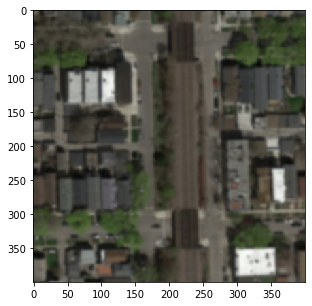

In [30]:
# Load a set of images
imgs, gt_imgs = load_training_images(n)
for i in range(len(imgs)) :
    imgs[i] = gaussian(imgs[i], sigma = 2, multichannel = True)
    
show_img(imgs[0])

In [31]:
# Extract patches from all images
img_patches = get_patches(imgs, patch_size)
gt_patches = get_patches(gt_imgs, patch_size)

In [32]:
# Get features for each image patch
X = get_features_from_patches(img_patches, extraction_func)
Ys = [get_labels_from_patches(gt_patches, t) for t in foreground_threshold]
Y = None
print(X.shape)

(62500, 6)


In [33]:
# Preprocessing
if preproc is not None:
    preproc = preproc.fit(X)
    X = preproc.transform(X)
print(X)

[[-0.6237879  -0.7514047  -0.79824615 -0.01123494 -0.00953956 -0.13188182]
 [-0.92137396 -1.0210809  -1.0324448  -0.35703546 -0.3358476  -0.36176923]
 [-0.6543674  -0.747111   -0.81503856 -0.56151396 -0.51159453 -0.50425833]
 ...
 [-1.9628719  -0.88683385 -0.5622973  -0.6858257  -0.62769544 -0.60236895]
 [-1.9653474  -0.84345186 -0.5327698  -0.68630016 -0.6282021  -0.60249746]
 [-1.988056   -0.85712904 -0.5431803  -0.68577707 -0.6278689  -0.6025583 ]]


## Cross-validation and parameters tuning

In [ ]:
split = StratifiedShuffleSplit(n_splits=k, random_state=seed)
search = GridSearchCV(model, param_grid, cv=split, scoring="f1")
score = -1
# Cross-validate with different foreground_threshold values.
for i, y in enumerate(Ys):
    # Grid search on the parameters, to find the best score.
    search.fit(X,y)
    print("Threshold={} : score={}".format(foreground_threshold[i], search.best_score_))
    if search.best_score_ > score:
        Y = y
        score = search.best_score_
        model = search.best_estimator_

In [ ]:
print("F1 score:", score)
print(model.get_params())

## Neural Network

In [34]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [37]:
# Model
# Neural network, using keras library. We chose this library as it has a user-friendly high-level API which makes it easy to try different NN models
model = keras.Sequential([
        keras.layers.Dense(32, input_dim=len(X[0])),
        keras.layers.Activation("relu"),
        keras.layers.Dense(32),
        keras.layers.Activation("relu"),
        keras.layers.Dense(128),
        keras.layers.Activation("relu"),
        keras.layers.Dense(128),
        keras.layers.Activation("relu"),
        keras.layers.Dense(32),
        keras.layers.Activation("relu"),
        keras.layers.Dense(1, activation='sigmoid')
    ])

# Use the adam optimizer
adam = keras.optimizers.Adam(lr=0.01)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[f1_m])

# Training
model.fit(X, Ys[0], epochs=20, validation_split=0.1)

Train on 56250 samples, validate on 6250 samples
Epoch 1/20
56250/56250 [==============================] - 2s 43us/sample - loss: 0.1514 - f1_m: 0.4374 - val_loss: 0.1393 - val_f1_m: 0.2583
Epoch 2/20
56250/56250 [==============================] - 2s 43us/sample - loss: 0.1447 - f1_m: 0.4889 - val_loss: 0.1385 - val_f1_m: 0.2402
Epoch 3/20
56250/56250 [==============================] - 2s 40us/sample - loss: 0.1430 - f1_m: 0.5025 - val_loss: 0.1359 - val_f1_m: 0.2887
Epoch 4/20
56250/56250 [==============================] - 2s 39us/sample - loss: 0.1417 - f1_m: 0.5102 - val_loss: 0.1397 - val_f1_m: 0.3351
Epoch 5/20
56250/56250 [==============================] - 2s 37us/sample - loss: 0.1406 - f1_m: 0.5214 - val_loss: 0.1399 - val_f1_m: 0.3642
Epoch 6/20
56250/56250 [==============================] - 3s 47us/sample - loss: 0.1400 - f1_m: 0.5242 - val_loss: 0.1356 - val_f1_m: 0.3133
Epoch 7/20
56250/56250 [==============================] - 2s 39us/sample - loss: 0.1399 - f1_m: 0.5249 - 

In [38]:
Z = model.predict(X)
Z = [1 if t >= 0.25 else 0 for t in Z]

## Predictions

In [39]:
# Predict on thetraining set
Z = model.predict(X)

TPR = true_positive_rate(Z, Y) 
TNR = true_negative_rate(Z, Y)
FPR = false_positive_rate(Z, Y)
FNR = false_negative_rate(Z, Y)
print('True positive rate = ' + str(TPR))
print('True negative rate = ' + str(TNR))
print('False positive rate = ' + str(FPR))
print('False negative rate = ' + str(FNR))

True positive rate = 0.0
True negative rate = 0.0
False positive rate = 0.0
False negative rate = 0.0


In [40]:
# Predict on test set and create submission
create_submission(model, extraction_func, patch_size, preproc, aggregate_threshold)

## Comparison of groundtruth and prediction

In [43]:
idx = 1
img = imgs[idx]
img = gaussian(img, sigma = 2, multichannel = True)
gt_img = gt_imgs[idx]

# Run predictions
Xi = get_features_from_img(img, extraction_func, patch_size)
Yi = get_labels_from_img(gt_img, foreground_threshold, patch_size)
if preproc is not None:
    Xi = preproc.transform(Xi)
Zi = model.predict(Xi)

In [44]:
Zi[:30]

array([[4.2260492e-01],
       [2.9587060e-01],
       [1.8966272e-01],
       [1.0703391e-01],
       [5.7221323e-02],
       [5.9634835e-02],
       [3.4242797e-01],
       [3.6809555e-01],
       [3.9076534e-01],
       [3.8714993e-01],
       [1.9831645e-01],
       [9.1285318e-02],
       [9.0065181e-02],
       [1.6637897e-01],
       [4.8069286e-01],
       [4.3395030e-01],
       [1.4409286e-01],
       [1.0765675e-01],
       [3.8167626e-01],
       [4.1266727e-01],
       [3.8825879e-01],
       [7.2900772e-02],
       [4.1170245e-01],
       [8.4414870e-02],
       [1.7399138e-01],
       [2.7618945e-02],
       [5.5504739e-02],
       [3.7308151e-01],
       [3.7124753e-04],
       [8.0480278e-03]], dtype=float32)

In [45]:
Zi = [1 if t >= 0.40 else 0 for t in Zi]
Zi[:30]

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [46]:
w = img.shape[0]
h = img.shape[1]
label_img = label_to_img(w, h, patch_size, patch_size, Yi)
predicted_img = label_to_img(w, h, patch_size, patch_size, Zi)

Groundtruth:


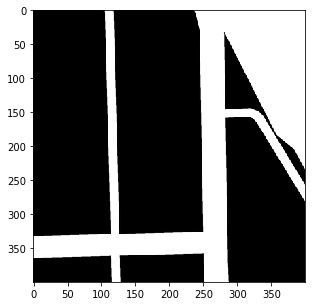

In [47]:
print("Groundtruth:")
show_img(gt_imgs[idx])

Patched groundtruth:


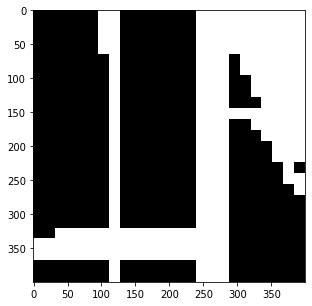

In [48]:
print("Patched groundtruth:")
show_img(label_img)

Predictions:


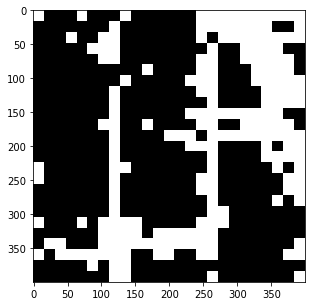

In [49]:
print("Predictions:")
show_img(predicted_img)

## Visualization of a single test image

In [50]:
# Load a test image
img_idx = 1

img_path = "Datasets/test_set_images/test_{0}/test_{0}.png".format(img_idx)
img = load_image(img_path)
img = gaussian(img, sigma = 2, multichannel = True)

In [51]:
# Run predictions
Xi = get_features_from_img(img, extraction_func, patch_size)
if preproc is not None:
    Xi = preproc.transform(Xi)
Zi = model.predict(Xi)

In [52]:
# threshold for labels 0 or 1
Zi = [1 if t >= 0.3 else 0 for t in Zi]

In [53]:
if Xi.shape[1] == 2:
    show_data_points(Xi, Zi)

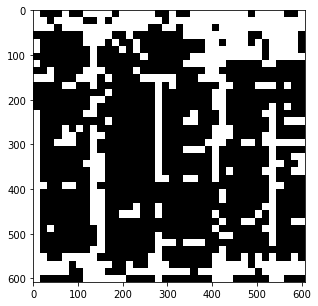

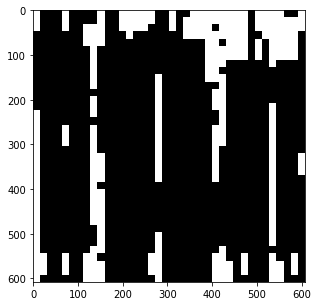

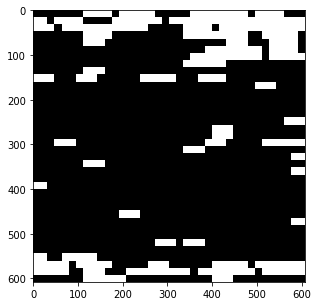

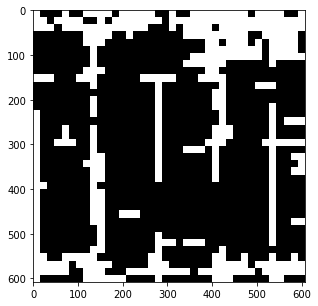

In [35]:
# Display prediction as an image
from skimage.morphology import  opening, closing, white_tophat
from skimage.morphology import square

w = img.shape[0]
h = img.shape[1]
side = int(np.sqrt(len(Zi)))
predicted_img = label_to_img(w, h, patch_size, patch_size, Zi)
kernel1 = square(3*16)
kernel2 = np.ones((4*16,1))
kernel3 = square(9*16)
kernel4 = np.ones((1,4*16))

kernel5 = np.ones((33,16))
kernel6 = np.ones((16,33))



predicted_img2 = closing(predicted_img, kernel1)
predicted_img2 = white_tophat(predicted_img2, kernel3)
predicted_img_vert = opening(predicted_img2, kernel2)

predicted_img_hor = opening(predicted_img2, kernel4)

show_img(predicted_img_vert)
show_img(predicted_img_hor)

predict_img_final = cv.addWeighted(predicted_img_vert,1,predicted_img_hor,1,0.0)

for x in range(len(predict_img_final)):
    for y in range(len(predict_img_final)):
        if predict_img_final[x][y] != 0 :
            predict_img_final[x][y] = 1
        
#show_img(predict_img_final)
show_img(predicted_img)


predicted_img5 = opening(predicted_img, kernel5)
predicted_img6 = opening(predicted_img, kernel6)
show_img(predicted_img5)
show_img(predicted_img6)

predict_img_final = cv.addWeighted(predicted_img5,1,predicted_img6,1,0.0)

for x in range(len(predict_img_final)):
    for y in range(len(predict_img_final)):
        if predict_img_final[x][y] != 0 :
            predict_img_final[x][y] = 1
            
show_img(predict_img_final)

#show_img_concatenated(img, predicted_img2)

## show_img_overlay(img, predicted_img2)

In [34]:
if patch_size != 16:
    Zi_agg = postprocessing.aggregate_labels(Zi, patch_size, 16, aggregate_threshold)
    predicted_img_agg = label_to_img(w, h, 16, 16, Zi_agg)
    show_img(predicted_img_agg)
    show_img_overlay(img, predicted_img_agg)

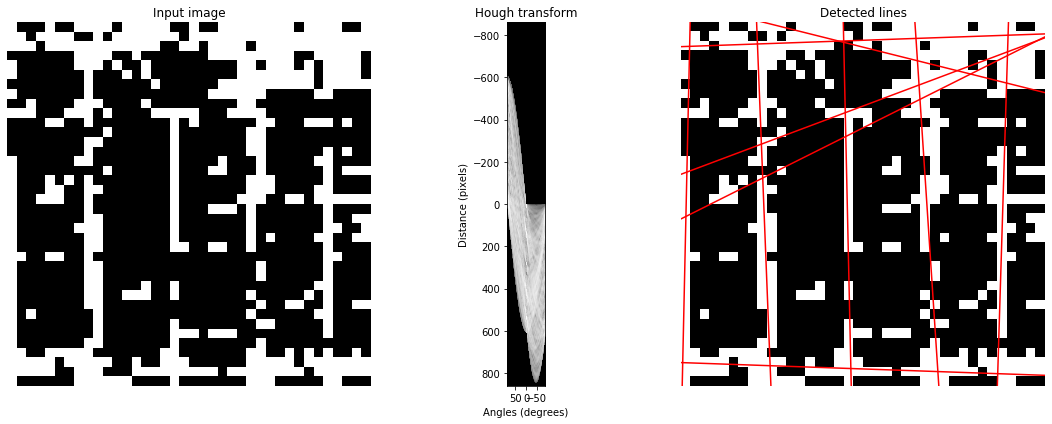

In [33]:
postprocessing.hough_transform(predicted_img)